# Interference of Trotterization (Grouping, Lattice)

In [1]:
## import necessary packages
import numpy as np
from scipy.linalg import expm

from trotter import *
from plot_config import *
from bounds import *
from lattice_hamiltonians import interference_bound, tight_bound
# from quantum_simulation_recipe import spin
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d, Power_Law

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['xtick.direction'] = 'out' # 'out'
mpl.rcParams['ytick.direction'] = 'out'

fig_dir, data_dir = './figs', './data'
# from lattice_hamiltonians import *

import jax
import jax.numpy as jnp
print('jax.device:', jax.devices())

jax.device: [CpuDevice(id=0)]


In [ ]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from numpy.linalg import norm
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt

class TF_Ising_1d:
    def __init__(self, n: int, J=1, h=0.2, g=0.0, pbc=False, verbose=False):
        self.n = n
        self.zz_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, n-1)]
        self.x_tuples = [('X', [i], -h) for i in range(0, n)] 
        self.z_tuples = [('Z', [i], -g) for i in range(0, n)] 
        if pbc: self.zz_tuples.append(('ZZ', [n-1, 0], -J))

        self.ham = SparsePauliOp.from_sparse_list([*self.zz_tuples, *self.x_tuples, *self.z_tuples], num_qubits=n).simplify()
        if verbose: print('The Hamiltonian: \n', self.ham)
        self.parity_group()
        self.xyz_group()

    def parity_group(self):
        # return self.ham.to_matrix().todense()
        self.ham_parity = [SparsePauliOp.from_sparse_list([*self.zz_tuples[::2], *self.x_tuples[::2], *self.z_tuples[::2]], num_qubits=self.n).simplify(), SparsePauliOp.from_sparse_list([*self.zz_tuples[1::2], *self.x_tuples[1::2], *self.z_tuples[1::2]], num_qubits=self.n).simplify()]

    def xyz_group(self):
        self.ham_xyz = [SparsePauliOp.from_sparse_list([*self.zz_tuples, *self.z_tuples], num_qubits=self.n).simplify(), SparsePauliOp.from_sparse_list([*self.x_tuples], num_qubits=self.n)]

def standard_trotter(h_list, t, r, ord=2, verbose=False):
    """
    [todo higher order]
    Args:
        h_list (list): A list of Hamiltonian terms (even/odd parity partition).
        t (float): The time step.

    Returns:

    """
    # list_U = [ssla.expm(-1j * (t / r) * herm) for herm in ising_1d.h_list]
    if ord == 2:
        list_U = [scipy.linalg.expm(-1j * (t / (2*r)) * herm.toarray()) for herm in h_list]
        if verbose: print('----expm Herm finished----')
        appro_U_dt = list_U[0] @ list_U[1]
        if verbose: print('----matrix product finished----')
        appro_U = np.linalg.matrix_power(appro_U_dt @ list_U[1] @ list_U[0], r)
        # appro_U = jnp.linalg.matrix_power(appro_U_dt, r)
        # appro_U = matrix_power(appro_U_dt, r)
        # appro_U = matrix_power(appro_U_dt.toarray(), r)
        if verbose: print('----matrix power finished----')
    elif ord == 1:
        list_U = [scipy.linalg.expm(-1j * (t / (r)) * herm.toarray()) for herm in h_list]
        appro_U_dt = list_U[0] @ list_U[1]
        appro_U = np.linalg.matrix_power(appro_U_dt, r)

    return appro_U

r_list:  [ 25  27  29  31  33  36  38  41  44  48  51  55  60  64  69  74  80  86
  92 100]


Text(0.5, 1.0, 'PF2, TFI (J=2, h=0.001), t=20, r=100')

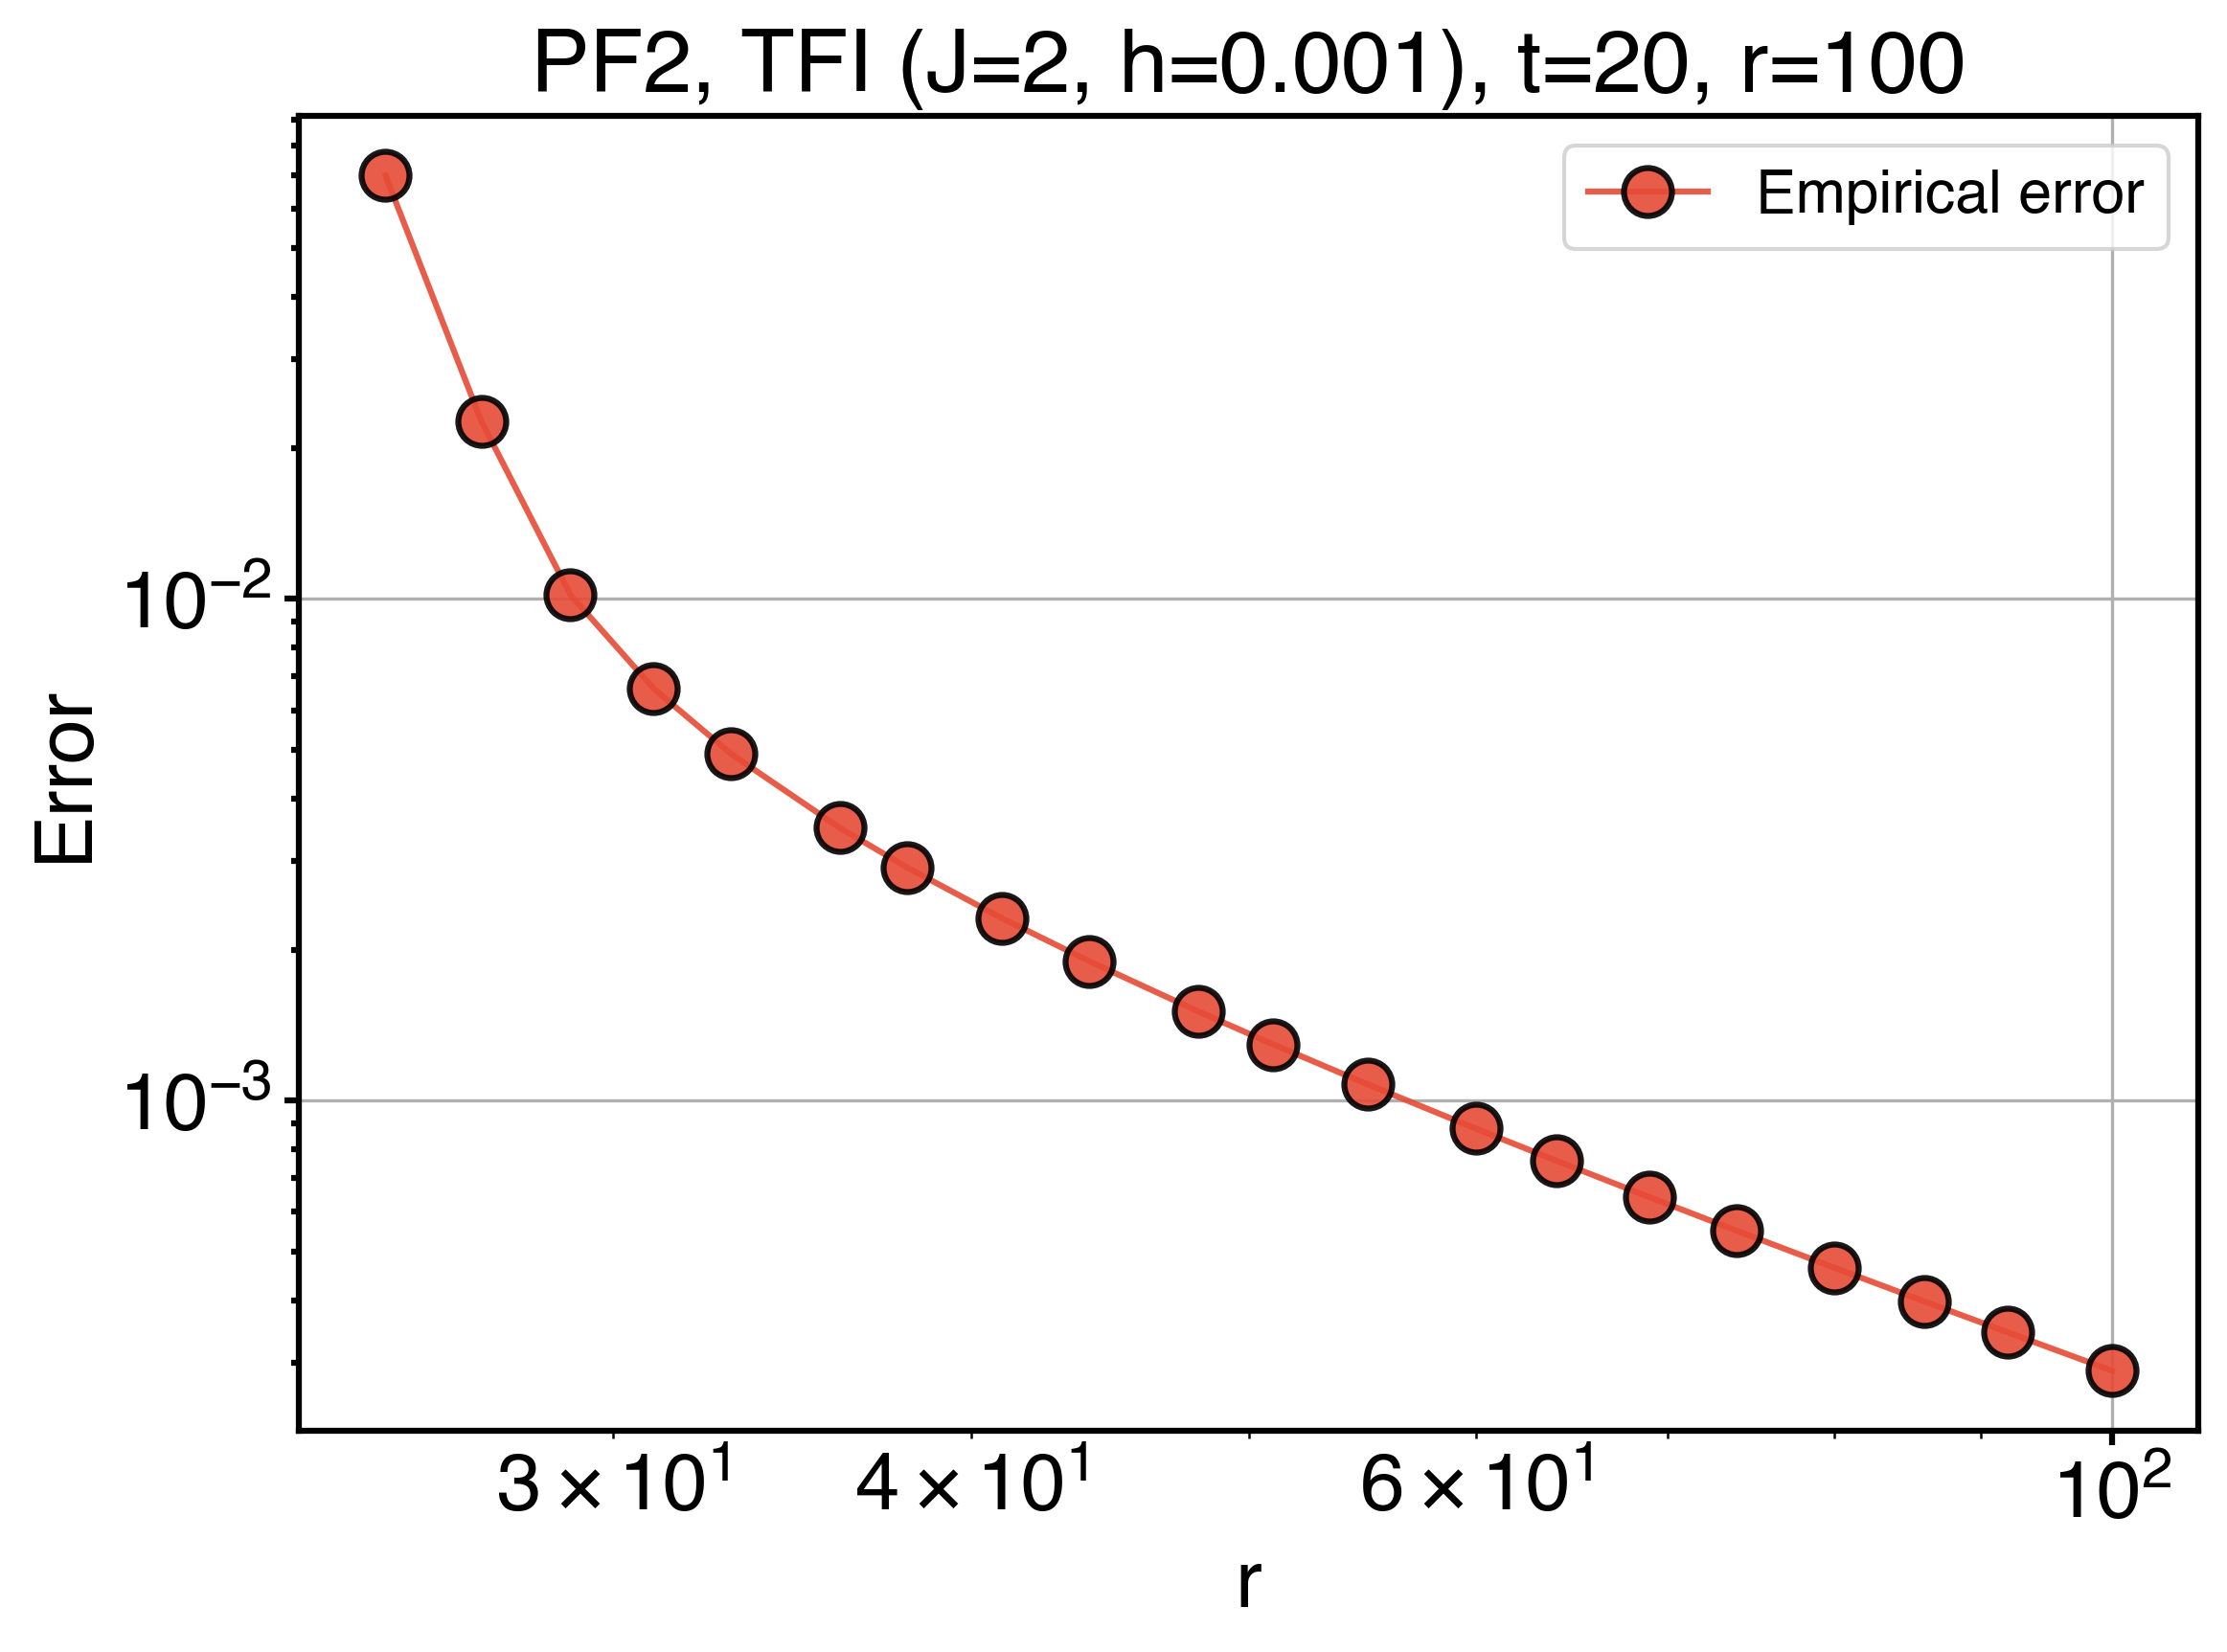

In [13]:
J, h = 2, 0.001
r_list = np.logspace(1.4, 2.0, 20, dtype=int)
# r_list = np.logspace(1, 1.5, 20, dtype=int)
print('r_list: ', r_list)
n = 8
err_list = []

for r in r_list:
    tfI = Nearest_Neighbour_1d(n=n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=True)
    # tfI = TF_Ising_1d(n, J, h)
    t = 20
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = pf_r([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    err_list.append(norm(exact_U - appro_U_xyz, ord=2))

fig, ax = plt.subplots(1, 1)
# ax.hlines(1e-3, r_list[0], r_list[-1], 'k', '--')
ax.plot(r_list, err_list, 'o-', label='Empirical error')
# ax.plot(r_list, [1.5/r**2 for r in r_list], 'k-', label=r'$r^{-2}$', alpha=0.3, linewidth=2)
# ax.plot(r_list, [0.9/r**2 for r in r_list], 'k-', alpha=0.3, linewidth=2)
# ax.plot(r_list, [2200/r**4 for r in r_list], 'k-', label=r'$r^{-4}$', alpha=0.3, linewidth=2)
# ax.plot(r_list, [3500/r**4 for r in r_list], 'k-', alpha=0.3, linewidth=2)
ax_set_text(ax, 'r', 'Error', log='xy')
ax.set_title(f'PF2, TFI (J={J}, h={h}), t={t}, r={r}')
# ax.set_ylim([3e-5, 5e-3])
# fig.savefig(f'./figs/PF2_TFI_err_n={n}_t={t}.pdf', dpi=300)

### x axis = t

t_list:  [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  85  86
  87  88  89  90  91  92  93  94  95  96  97  98 100]


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


a_em: 2.1647727417782354; b_em: -11.940122745375058


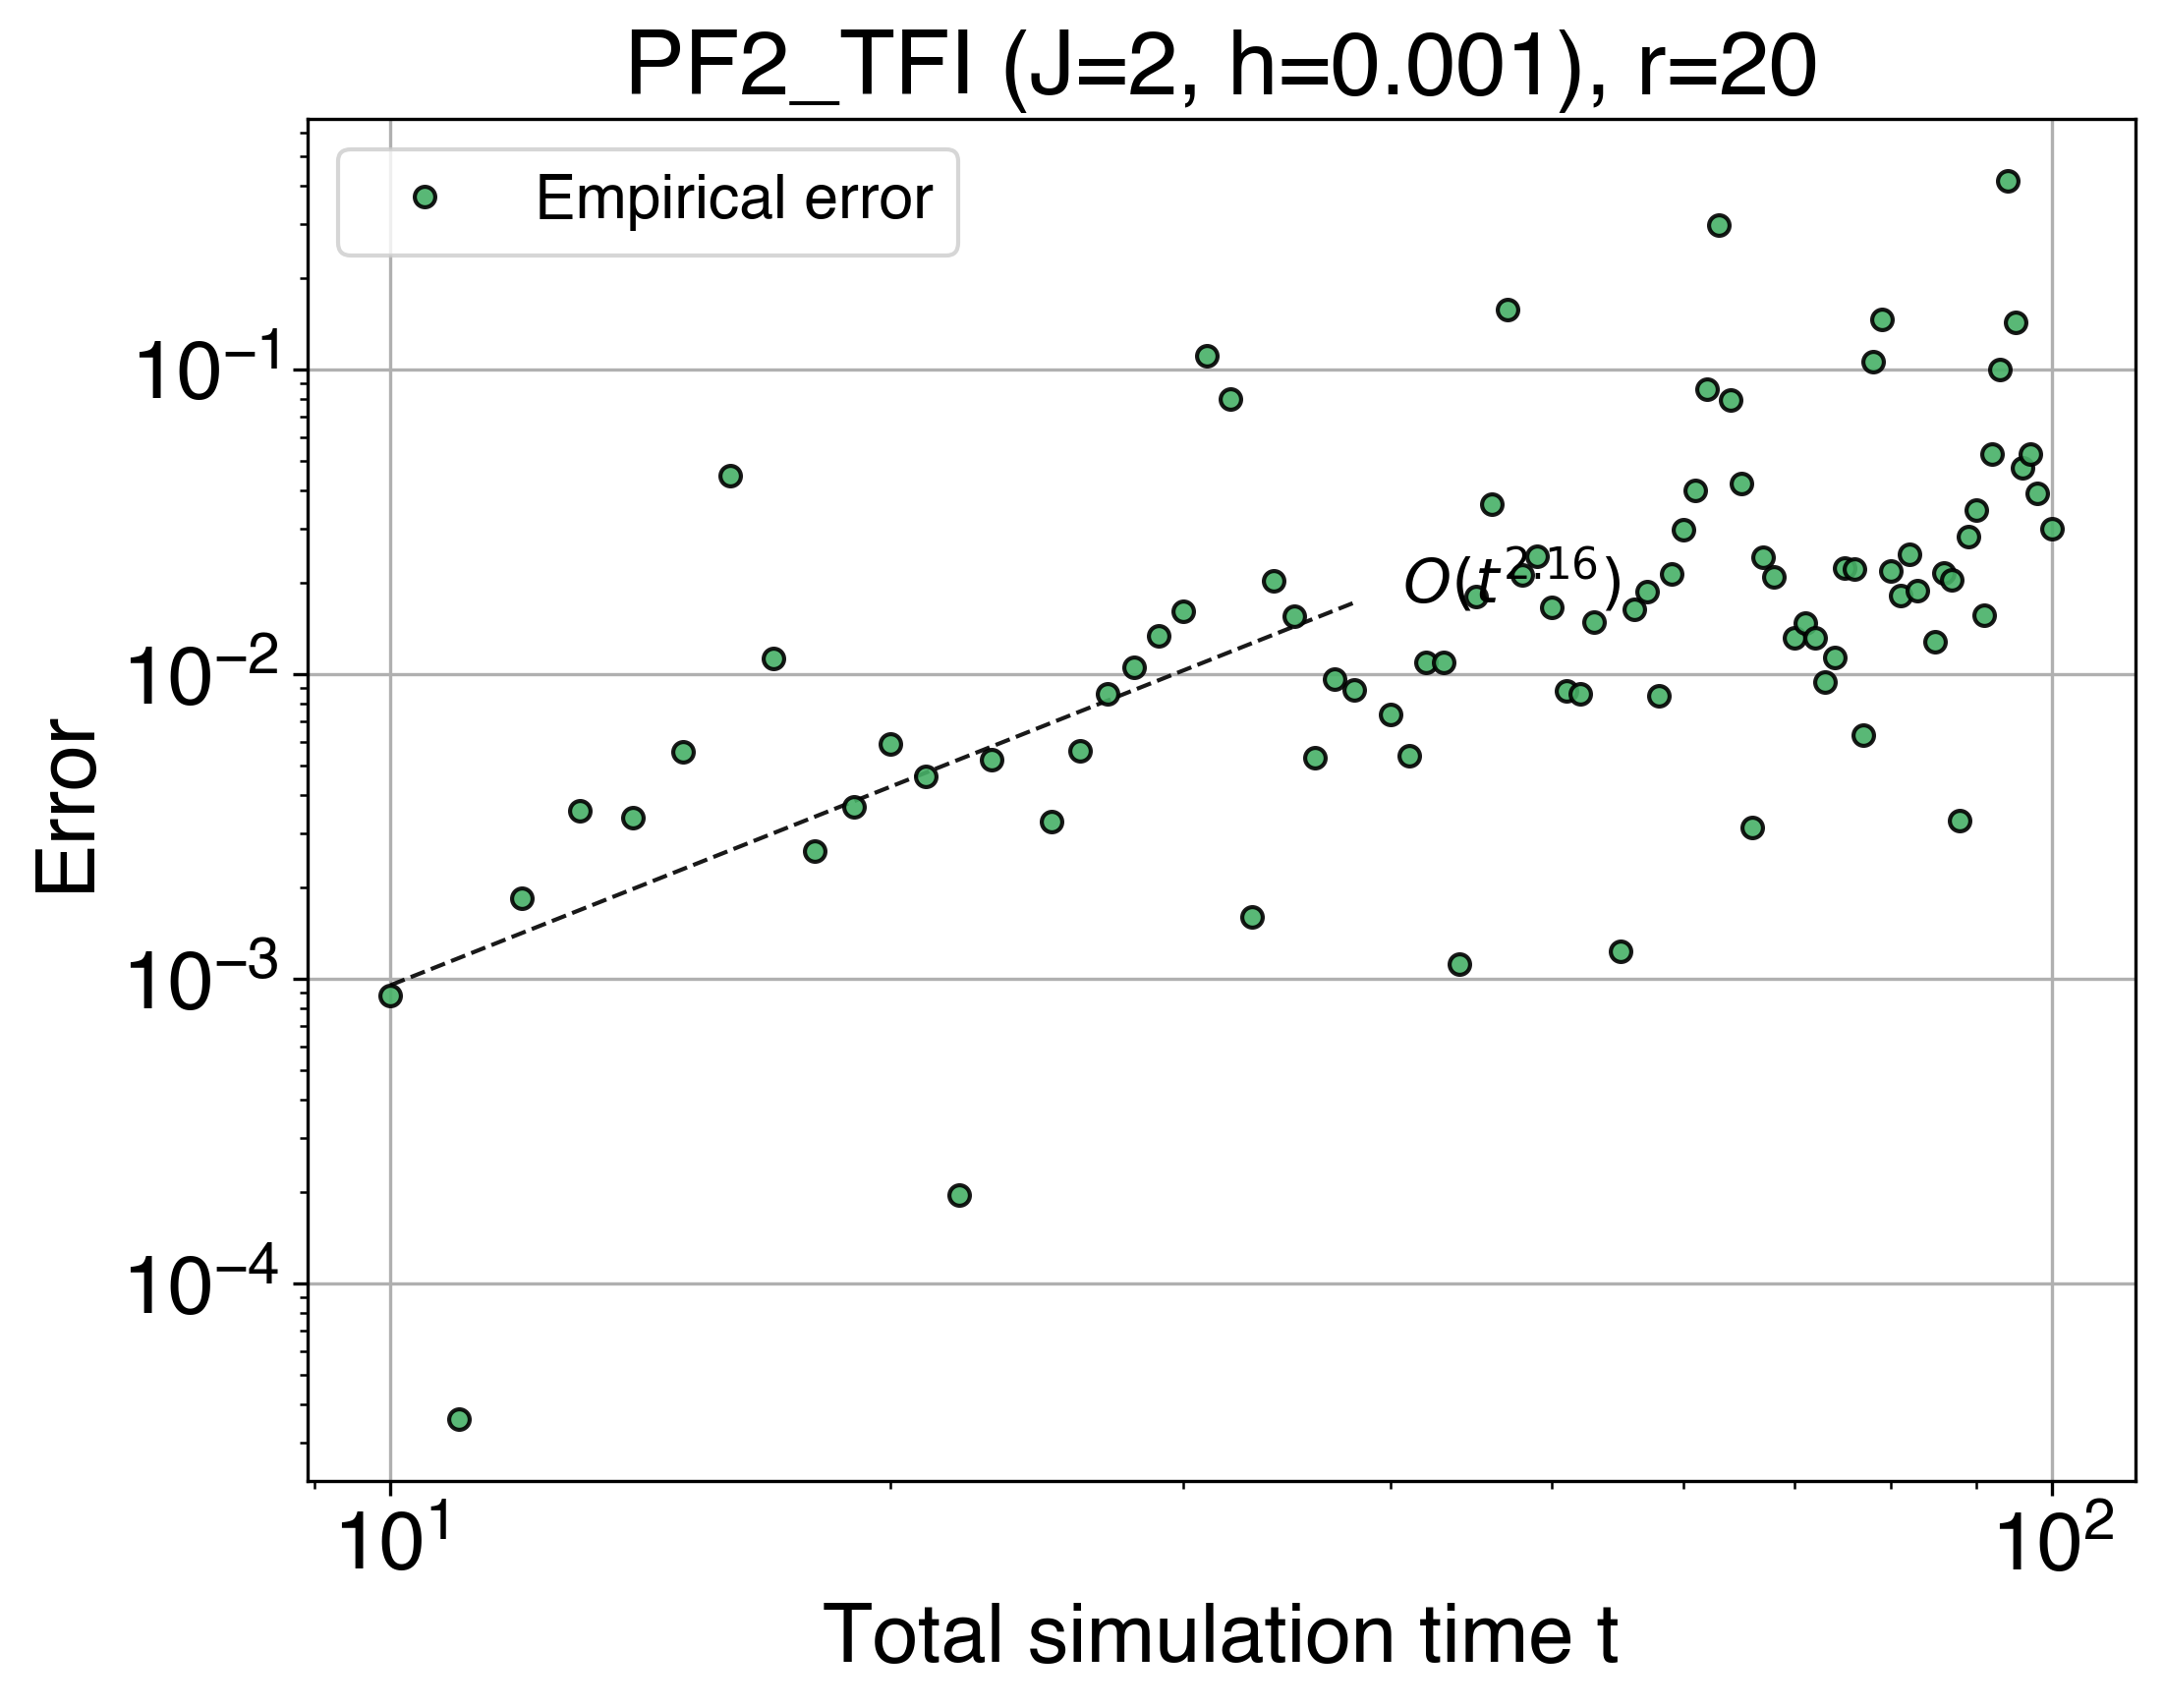

In [86]:
J=2; h=0.001; 
prefix = 'PF2_TFI'
# t_list = np.logspace(1, 3, 55, dtype=int)
t_list = np.linspace(10, 100, 85, dtype=int)
print('t_list: ', t_list)
n = 7
err_list = []

r = 20
for t in t_list:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r, ord=2)
    err_list.append(norm(exact_U - appro_U_xyz, ord=2))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.hlines(1e-3, t_list[0], t_list[-1], 'k', '--')
plot_fit(ax, t_list[:int(len(t_list)/3)], err_list[:int(len(t_list)/3)], var='t', offset=1.07, verbose=True)
# plot_fit(ax, t_list[int(8*len(t_list)/10):], err_list[int(8*len(t_list)/10):], var='t', offset=1.07, verbose=True)

# ax.plot(t_list, [t**3/1000000000 for t in t_list], 'k-', linewidth=2, alpha=0.3, label=fr'$\propto t^3$')
# ax.plot(t_list, [t**3/5000000000 for t in t_list], 'k-', linewidth=2, alpha=0.3)
# ax.plot(t_list, [t/20000 for t in t_list], 'k-', linewidth=2, alpha=0.3, label=fr'$\propto t$')
# ax.plot(t_list, [t/50000 for t in t_list], 'k-', linewidth=2, alpha=0.3)
ax.plot(t_list, err_list, '.', label='Empirical error')
ax.set_xlabel('Total simulation time t')
ax.set_ylabel('Error')
ax.set_title(f'{prefix} (J={J}, h={h}), r={r}')
ax.loglog()
# ax.set_ylim([1e-4, 1e-0])
ax.legend(); ax.grid()
fig.savefig(f'./figs/{prefix}_err_n={n}_r={r}.pdf', dpi=300)

t_list:  [  10   10   11   12   12   13   14   15   16   17   18   19   21   22
   23   25   27   28   30   32   34   36   39   41   44   47   50   53
   57   60   64   68   73   77   82   88   93  100  106  113  120  128
  136  145  154  164  175  186  198  211  224  238  254  270  288  306
  326  347  369  393  418  445  473  504  536  571  607  646  688  732
  779  829  882  939 1000]
a_em: 2.9155873489145625; b_em: -20.90670525962538


(0.0001, 1.0)

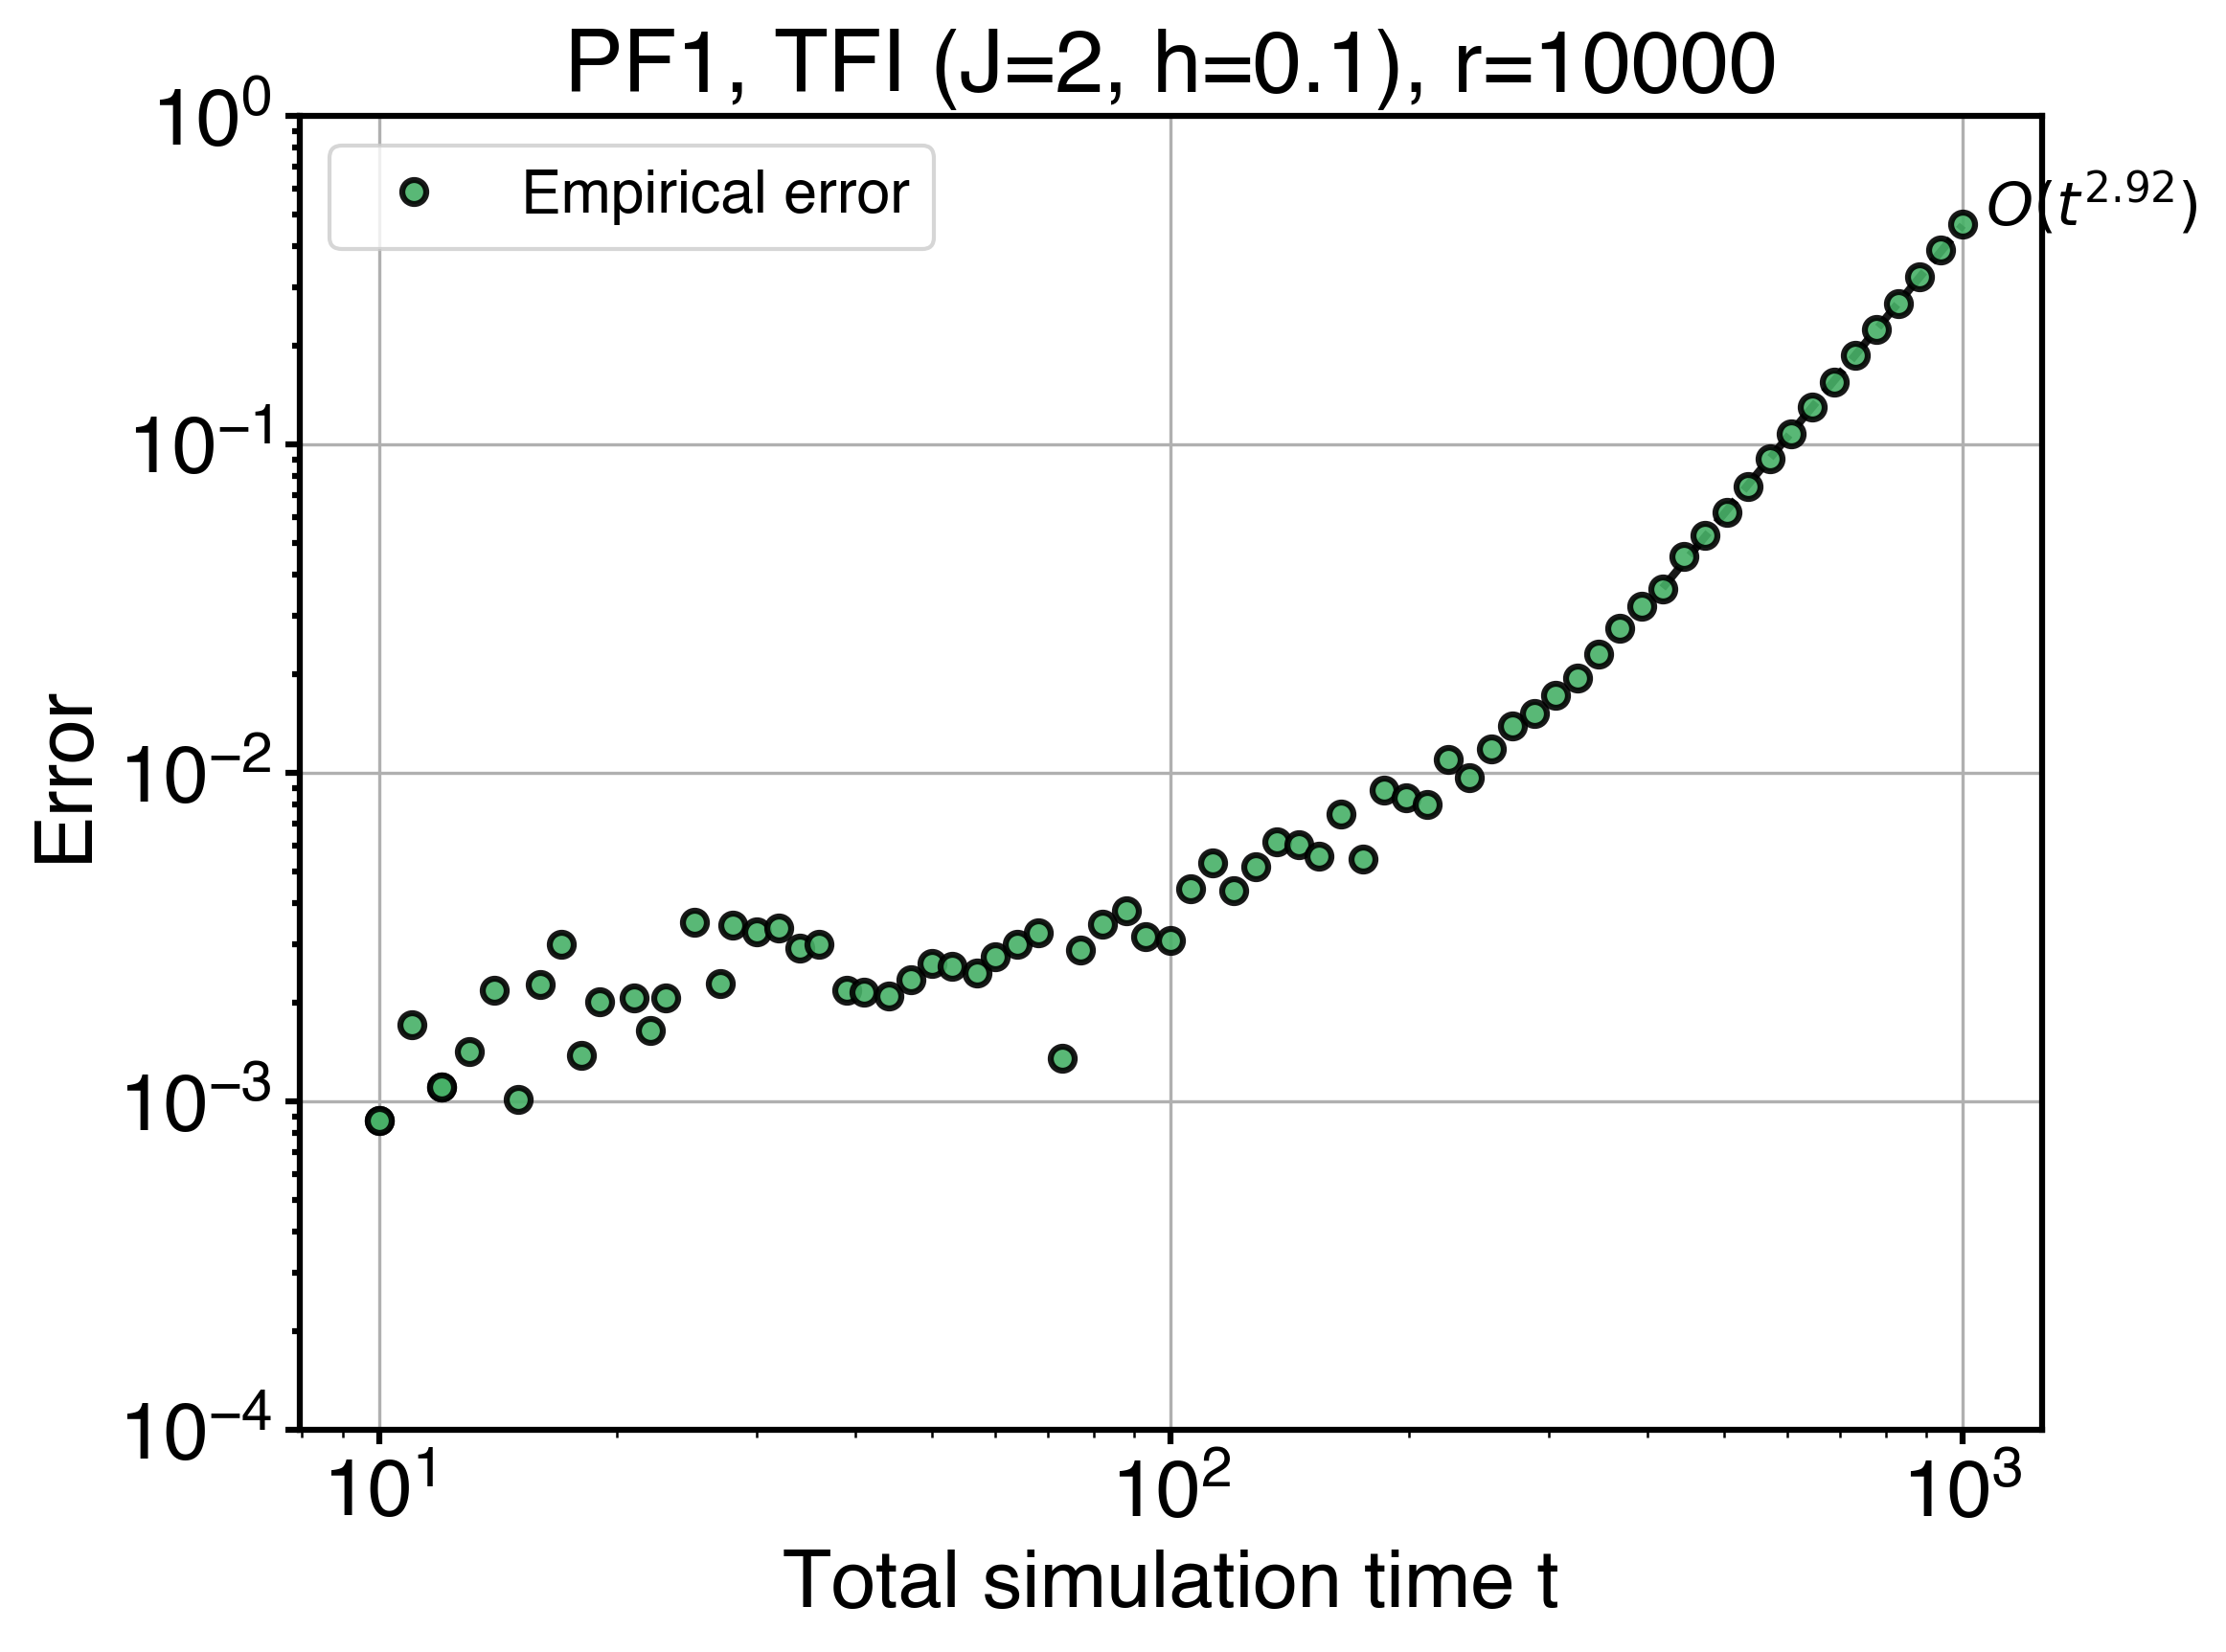

In [18]:
J=2; h=0.1; 
t_list = np.logspace(1, 3, 75, dtype=int)
print('t_list: ', t_list)
n = 7
err_list = []

r = 10000
for t in t_list:
    tfI = Nearest_Neighbour_1d(n=n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=True)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = pf_r([h.to_matrix(True) for h in tfI.ham_xyz], t, r, order=1)
    err_list.append(norm(exact_U - appro_U_xyz, ord=2))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.hlines(1e-3, t_list[0], t_list[-1], 'k', '--')
# plot_fit(ax, t_list[:int(len(t_list)/2)], err_list[:int(len(t_list)/2)], var='t', offset=1.07, verbose=True)
plot_fit(ax, t_list[int(8*len(t_list)/10):], err_list[int(8*len(t_list)/10):], var='t', x_offset=1.07, verbose=True)

# ax.plot(t_list, [t**3/1000000000 for t in t_list], 'k-', linewidth=2, alpha=0.3, label=fr'$\propto t^3$')
# ax.plot(t_list, [t**3/5000000000 for t in t_list], 'k-', linewidth=2, alpha=0.3)
# ax.plot(t_list, [t/20000 for t in t_list], 'k-', linewidth=2, alpha=0.3, label=fr'$\propto t$')
# ax.plot(t_list, [t/50000 for t in t_list], 'k-', linewidth=2, alpha=0.3)
ax.plot(t_list, err_list, '.', label='Empirical error')
ax_set_text(ax, 'Total simulation time t', 'Error', log='xy')
ax.set_title(f'PF1, TFI (J={J}, h={h}), r={r}')
ax.set_ylim([1e-4, 1e-0])
# fig.savefig(f'{fig_dir}/PF1_TFI_err_n={n}_r={r}.pdf', dpi=300)

In [5]:
from scipy.sparse import csr_matrix
np.set_printoptions(precision=6, suppress=True)

err_norm = 'spectral' # HS, spectral
n_qubit = 6; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]

r_mat = parity_group[0] @ parity_group[1] - parity_group[1] @ parity_group[0]
eigenvals, eigenvecs = np.linalg.eigh(parity_group[0] + parity_group[1])
print(np.array(sorted(eigenvals)))
r_mat_trans = np.linalg.inv(eigenvecs) @ r_mat @ eigenvecs
print(np.array(r_mat_trans))

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIII', 'IXXIII', 'IIXXII', 'IIIXXI', 'IIIIXX', 'XIIIIX']
inter_yy: ['YYIIII', 'IYYIII', 'IIYYII', 'IIIYYI', 'IIIIYY', 'YIIIIY']
inter_zz: ['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIIZ']
external ['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIII', 'IIXXII', 'IIIIXX']
inter_xx_odd: ['IXXIII', 'IIIXXI', 'XIIIIX']
external_even ['ZIIIII', 'IIZIII', 'IIIIZI']
external_odd ['IZIIII', 'IIIZII', 'IIIIIZ']
[-22.422205 -17.944272 -16.944272 -15.944272 -12.       -11.246211
 -11.246211 -10.246211 -10.246211  -9.246211  -9.246211  -9.
  -9.        -8.        -8.        -7.        -7.        -6.
  -5.        -4.        -4.        -4.        -3.        -2.
  -2.        -2.        -1.        -1.        -0.055728   0.
   0.         0.944272   1.         1.         1.944272   2.
   2.         3.         4.         5.         5.246211   5.246211
   6.         6

## Heisenberg model

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX', 'XIIIIIIX']
inter_yy: ['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY', 'YIIIIIIY']
inter_zz: ['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'ZIIIIIIZ']
external ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIIII', 'IIXXIIII', 'IIIIXXII', 'IIIIIIXX']
inter_xx_odd: ['IXXIIIII', 'IIIXXIII', 'IIIIIXXI', 'XIIIIIIX']
external_even ['ZIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIIIIIZI']
external_odd ['IZIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIIIIIZ']


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


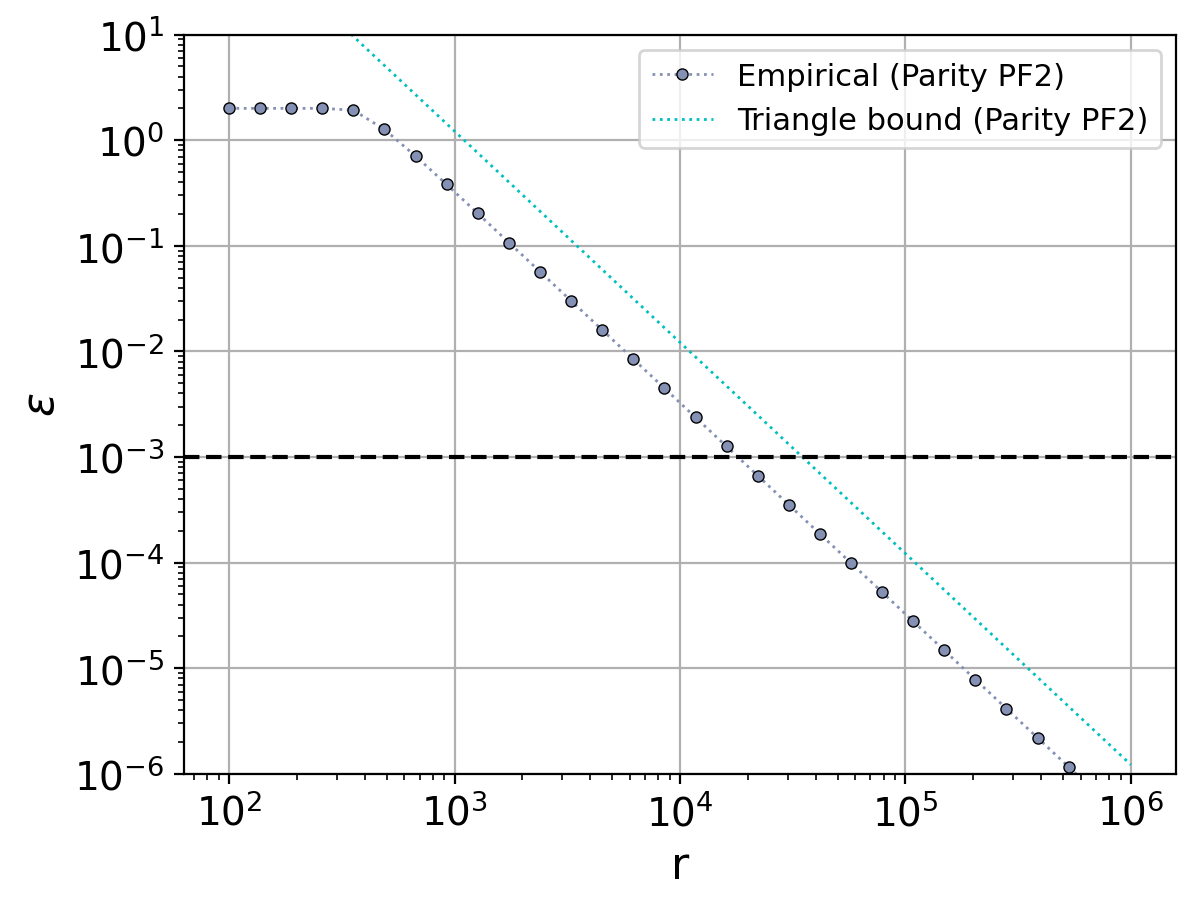

In [6]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n_qubit = 8; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]

r_list = np.logspace(2, 6, num=30, dtype=int)
# r_list = np.logspace(1, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

# interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])
e_pf2_tight_parity = np.array([tight_bound(parity_group, 2, t, r) for r in r_list])
e_pf1_tight_parity = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(parity_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_parity_list = [op_error((unitary_matrix_product(parity_group_sparse, t=t/(2*r))@unitary_matrix_product(parity_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]
# data_plot(r_list, pf1_parity_list, 'r.--', label= 'Empirical (Parity PF1)')
data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical (Parity PF2)')

# data_plot(r_list, interf_bound[:, 0], 'r-', linewidth=1.4, label=r'Interference (L=2)')
# data_plot(r_list, e_pf1_tight_parity, 'r--', label=r'Tight bound (Parity PF1)', linewidth=1)
data_plot(r_list, e_pf2_tight_parity, 'c:', label=r'Triangle bound (Parity PF2)', linewidth=1)

plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylim(1e-6, 1e1)
plt.ylabel(r'$\epsilon$')
# plt.title(rf'Nearest Neighbor Heisenberg, n={n_qubit}, t={t}')
plt.legend(fontsize=11, loc='upper right')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/bi_group_n={n_qubit}_t={t}.pdf', bbox_inches='tight')

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX', 'XIIIIIIX']
inter_yy: ['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY', 'YIIIIIIY']
inter_zz: ['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'ZIIIIIIZ']
external ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIIII', 'IIXXIIII', 'IIIIXXII', 'IIIIIIXX']
inter_xx_odd: ['IXXIIIII', 'IIIXXIII', 'IIIIIXXI', 'XIIIIIIX']
external_even ['ZIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIIIIIZI']
external_odd ['IZIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIIIIIZ']


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


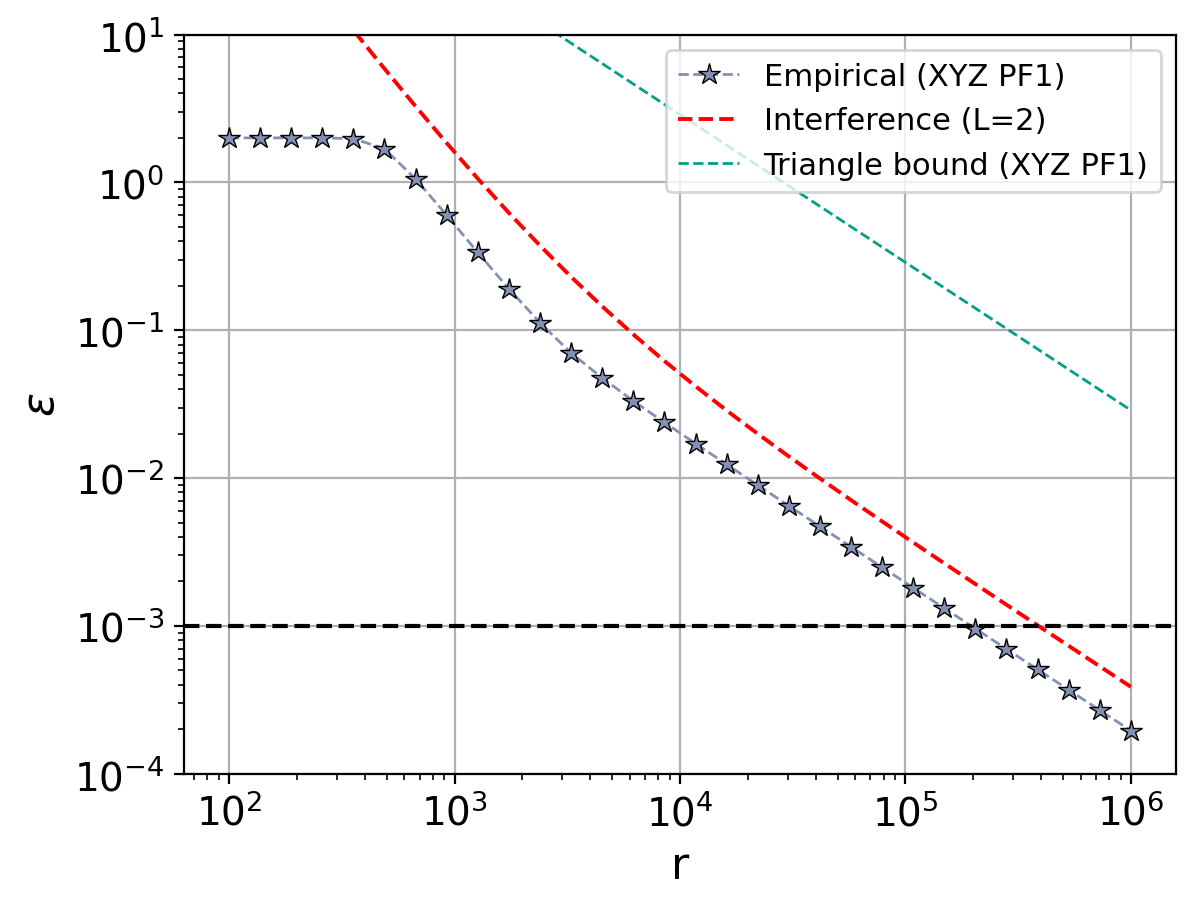

In [7]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n_qubit = 8; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

tri_group_sparse = [csr_matrix(heisenberg.term0), csr_matrix(heisenberg.term1), csr_matrix(heisenberg.term2)]
tri_group = [heisenberg.term0.to_matrix(), heisenberg.term1.to_matrix(), heisenberg.term2.to_matrix()]

r_list = np.logspace(2, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group_sparse = [csr_matrix(heisenberg.xx), csr_matrix(heisenberg.yy), csr_matrix(heisenberg.zz) + csr_matrix(heisenberg.z)]
xyz_group = [heisenberg.xx.to_matrix() , heisenberg.yy.to_matrix(), heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()]
# xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
# e_pf1_tight_parity = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])
# e_pf1_tight_tri = np.array([tight_bound(tri_group, 1, t, r) for r in r_list])
# e_pf2_tight = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])

tri_bound = np.array([triangle_bound(xyz_group, 1, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(xyz_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf1_tri_list = [op_error(unitary_matrix_product(tri_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_parity_list = [op_error(matrix_power(pf(parity_group, 2, t=t/r), r), exact_U) for r in r_list]
# data_plot(r_list, pf1_tri_list, '.--', label= 'Empirical (Tri PF1)')
# data_plot(r_list, pf1_parity_list, '.--', label= 'Empirical (Parity PF1)')
# data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical (Parity PF2)')

pf1_xyz_list = [op_error(unitary_matrix_product(xyz_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_xyz_list = [op_error(matrix_power(pf(xyz_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
# data_plot(r_list, pf2_xyz_list, '*:', label= 'Empirical (XYZ PF2)')

data_plot(r_list, interf_bound[:, 0], 'r--', linewidth=1.4, label=r'Interference (L=2)')
# data_plot(r_list, e_pf1_tight_tri, '-', label=r'tight bound (Tri PF1)', linewidth=1)
# data_plot(r_list, e_pf1_tight_parity, '-', label=r'tight bound (Parity PF1)', linewidth=1)
data_plot(r_list, e_pf1_tight_xyz, '--', label=r'Triangle bound (XYZ PF1)', linewidth=1)
# data_plot(r_list, e_pf2_tight, '-', label=r'tight bound (XYZ PF2)', linewidth=1)
# data_plot(r_list, tri_bound, 'p--', label=r'triangle?loose  (XYZ PF1)', linewidth=1, alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf1, 'p--', label=r'analytic bound (XYZ PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf2, 'p:', label=r'analytic bound (XYZ PF2)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf1, '^--', label=r'analytic bound (parity PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf2, '^:', label=r'analytic bound (parity PF2)', alpha=0.6)

# data_plot(r_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
# data_plot(r_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
# data_plot(r_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.ylim(1e-4, 1e1)
# plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, t={t}, norm={err_norm})')
plt.legend(fontsize=11, loc='upper right')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/tri_group_n={n_qubit}_t={t}_xyz.pdf', bbox_inches='tight')

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIII', 'IXXIIII', 'IIXXIII', 'IIIXXII', 'IIIIXXI', 'IIIIIXX', 'XIIIIIX']
inter_yy: ['YYIIIII', 'IYYIIII', 'IIYYIII', 'IIIYYII', 'IIIIYYI', 'IIIIIYY', 'YIIIIIY']
inter_zz: ['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'ZIIIIIZ']
external ['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIII', 'IIXXIII', 'IIIIXXI', 'XIIIIIX']
inter_xx_odd: ['IXXIIII', 'IIIXXII', 'IIIIIXX']
external_even ['ZIIIIII', 'IIZIIII', 'IIIIZII', 'IIIIIIZ']
external_odd ['IZIIIII', 'IIIZIII', 'IIIIIZI']


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


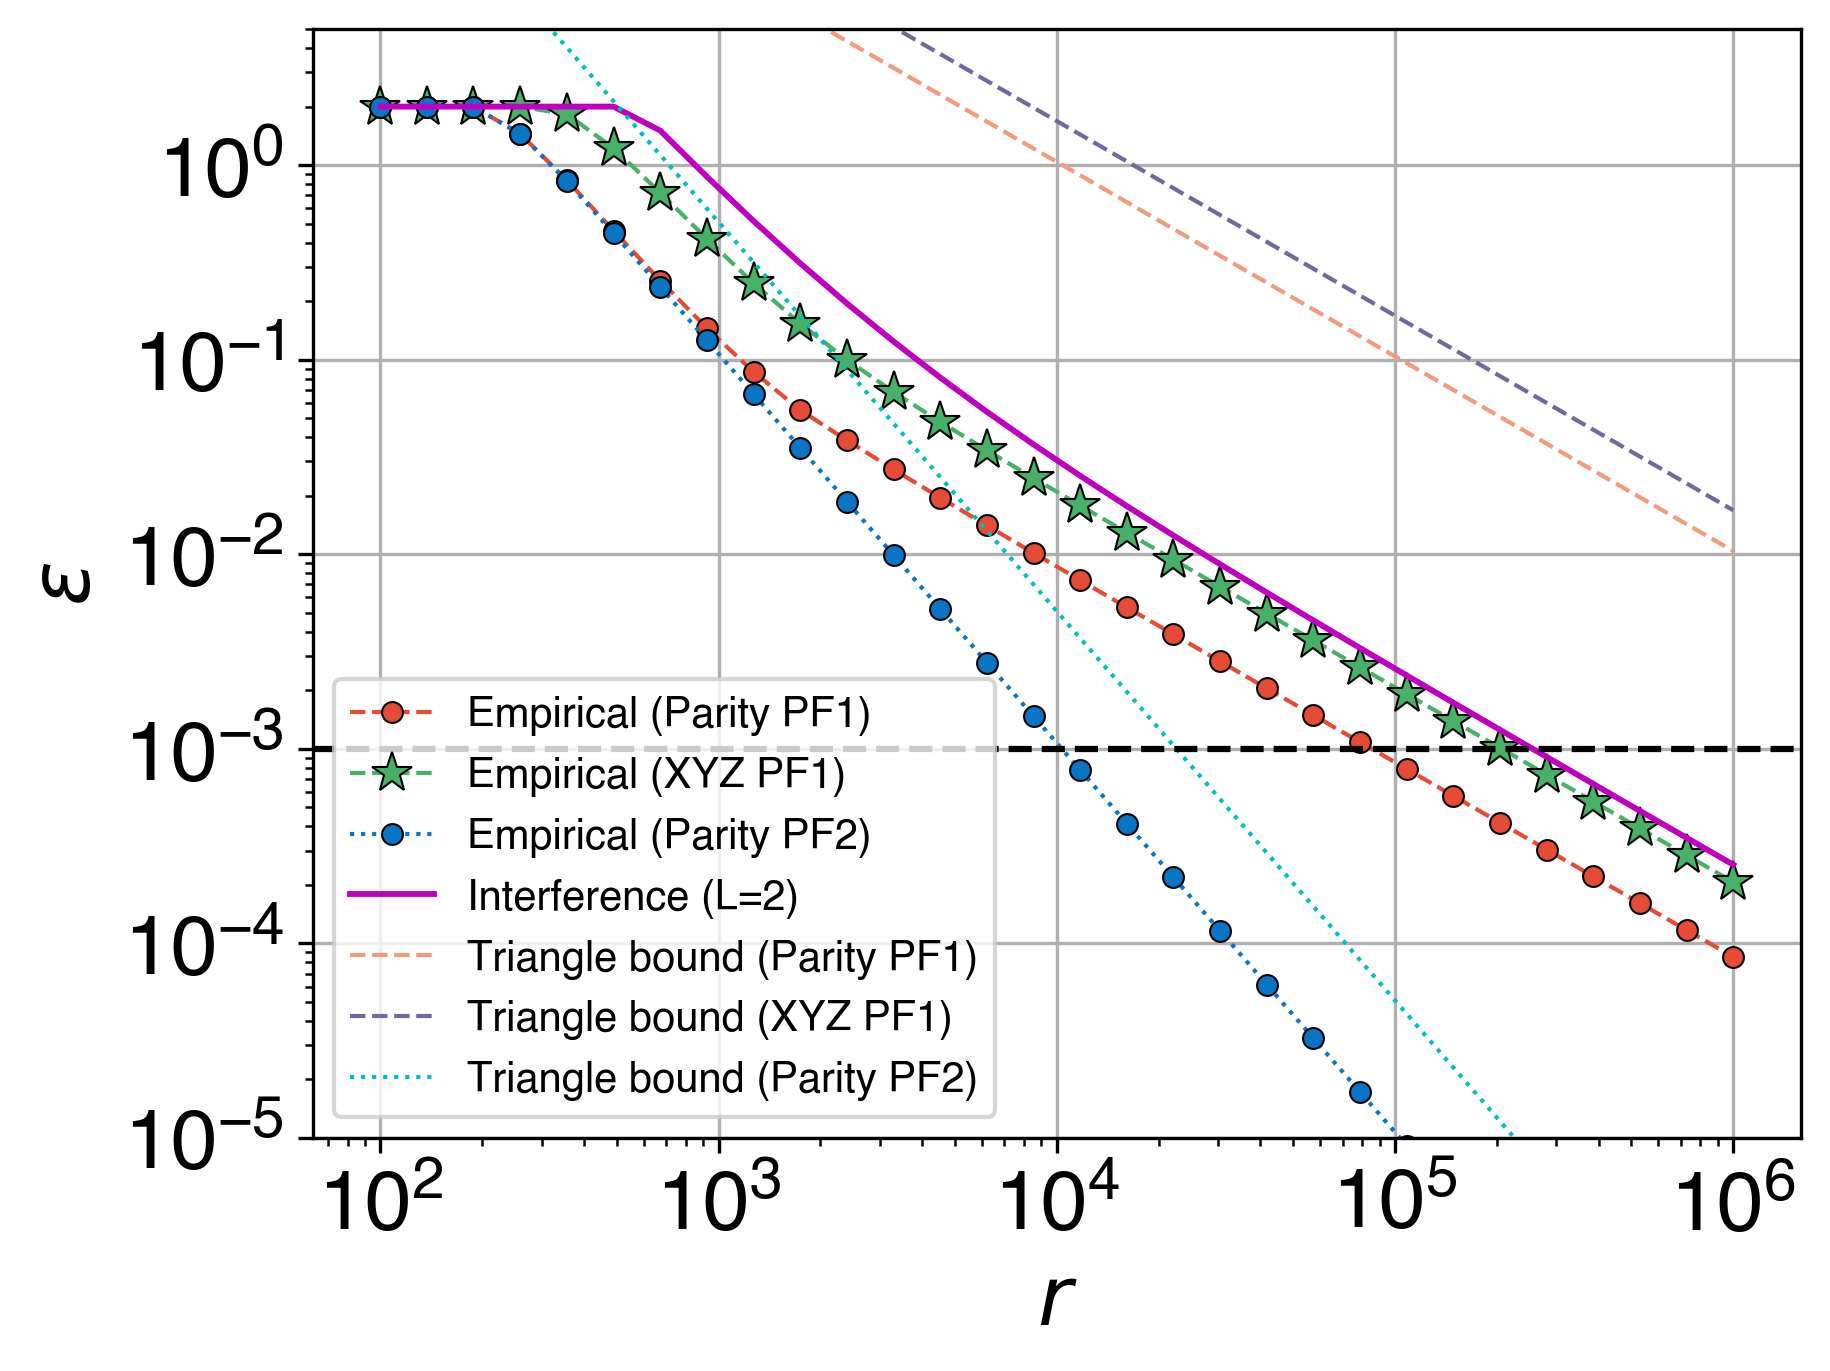

In [3]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n_qubit = 7; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

tri_group_sparse = [csr_matrix(heisenberg.term0), csr_matrix(heisenberg.term1), csr_matrix(heisenberg.term2)]
tri_group = [heisenberg.term0.to_matrix(), heisenberg.term1.to_matrix(), heisenberg.term2.to_matrix()]

r_list = np.logspace(2, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group_sparse = [csr_matrix(heisenberg.xx), csr_matrix(heisenberg.yy), csr_matrix(heisenberg.zz) + csr_matrix(heisenberg.z)]
xyz_group = [heisenberg.xx.to_matrix() , heisenberg.yy.to_matrix(), heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()]
# xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf1_tight_parity = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])
e_pf2_tight_parity = np.array([tight_bound(parity_group, 2, t, r) for r in r_list])
# e_pf1_tight_tri = np.array([tight_bound(tri_group, 1, t, r) for r in r_list])
# e_pf2_tight = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])

tri_bound = np.array([triangle_bound(xyz_group, 1, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(xyz_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_parity_list = [op_error((unitary_matrix_product(parity_group_sparse, t=t/(2*r))@unitary_matrix_product(parity_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]
pf1_tri_list = [op_error(unitary_matrix_product(tri_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_parity_list = [op_error(matrix_power(pf(parity_group, 2, t=t/r), r), exact_U) for r in r_list]
# data_plot(r_list, pf1_tri_list, '.--', label= 'Empirical (Tri PF1)')
data_plot(r_list, pf1_parity_list, '.--', label= 'Empirical (Parity PF1)')

pf1_xyz_list = [op_error(unitary_matrix_product(xyz_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_xyz_list = [op_error(matrix_power(pf(xyz_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical (Parity PF2)')
# data_plot(r_list, pf2_xyz_list, '*:', label= 'Empirical (XYZ PF2)')

data_plot(r_list, interf_bound[:, 0], 'm-', linewidth=1.4, label=r'Interference (L=2)')
# data_plot(r_list, e_pf1_tight_tri, '-', label=r'tight bound (Tri PF1)', linewidth=1)
data_plot(r_list, e_pf1_tight_parity, '--', label=r'Triangle bound (Parity PF1)', linewidth=1)
data_plot(r_list, e_pf1_tight_xyz, '--', label=r'Triangle bound (XYZ PF1)', linewidth=1)
data_plot(r_list, e_pf2_tight_parity, 'c:', label=r'Triangle bound (Parity PF2)', linewidth=1)
# data_plot(r_list, e_pf2_tight, '-', label=r'tight bound (XYZ PF2)', linewidth=1)
# data_plot(r_list, tri_bound, 'p--', label=r'triangle?loose  (XYZ PF1)', linewidth=1, alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf1, 'p--', label=r'analytic bound (XYZ PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf2, 'p:', label=r'analytic bound (XYZ PF2)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf1, '^--', label=r'analytic bound (parity PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf2, '^:', label=r'analytic bound (parity PF2)', alpha=0.6)

# data_plot(r_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
# data_plot(r_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
# data_plot(r_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$r$')
plt.ylabel(r'$\epsilon$')
plt.ylim(1e-5, 5e0)
# plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, t={t}, norm={err_norm})')
plt.legend(fontsize=10, loc='lower left')
plt.grid()
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/NNH_n={n_qubit}_t={t}_xyz_parity.pdf', bbox_inches='tight')

In [6]:
n_qubit = 8; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

r_list = np.logspace(1, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz + heisenberg.z]
# xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
e_pf1_tight = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf2_tight = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])

tri_bound = np.array([triangle_bound(xyz_group, 1, t, r) for r in r_list])

# ana_bound_xyz_pf1 = np.array([analytic_bound(xyz_group, 1/2, t, r) for r in r_list_truncated])
# ana_bound_xyz_pf2 = np.array([analytic_bound(xyz_group, 2/2, t, r) for r in r_list_truncated])

# ana_bound_parity_pf1 = np.array([analytic_bound(parity_group, 1/2, t, r) for r in r_list_truncated])
# ana_bound_parity_pf2 = np.array([analytic_bound(parity_group, 2/2, t, r) for r in r_list_truncated])

exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(matrix_power(unitary_matrix_product(parity_group, t=t/r), r), exact_U) for r in r_list]
# pf2_parity_list = [op_error(matrix_power(pf(parity_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_parity_list, '.--', label= 'Empirical even/odd PF1')
# data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical even/odd PF2')

pf1_xyz_list = [op_error(matrix_power(unitary_matrix_product(xyz_group, t=t/r), r), exact_U) for r in r_list]
# pf2_xyz_list = [op_error(matrix_power(pf(xyz_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
# data_plot(r_list, pf2_xyz_list, '*:', label= 'Empirical (XYZ PF2)')

data_plot(r_list, interf_bound[:, 0], 'r-', linewidth=1.4, label=r'Interference (L=2)')
data_plot(r_list, e_pf1_tight, '-', label=r'tight bound (XYZ PF1)', linewidth=1)
data_plot(r_list, e_pf2_tight, '-', label=r'tight bound (XYZ PF2)', linewidth=1)
data_plot(r_list, tri_bound, 'p--', label=r'triangle?loose  (XYZ PF1)', linewidth=1, alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf1, 'p--', label=r'analytic bound (XYZ PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf2, 'p:', label=r'analytic bound (XYZ PF2)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf1, '^--', label=r'analytic bound (parity PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf2, '^:', label=r'analytic bound (parity PF2)', alpha=0.6)

data_plot(r_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
data_plot(r_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
data_plot(r_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, t={t})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/bound_1from2_n={n_qubit}_t={t}.pdf', bbox_inches='tight')

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX', 'XIIIIIIX']
inter_yy: ['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY', 'YIIIIIIY']
inter_zz: ['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'ZIIIIIIZ']
external ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIIII', 'IIXXIIII', 'IIIIXXII', 'IIIIIIXX']
inter_xx_odd: ['IXXIIIII', 'IIIXXIII', 'IIIIIXXI', 'XIIIIIIX']
external_even ['ZIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIIIIIZI']
external_odd ['IZIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIIIIIZ']


AttributeError: 'Operator' object has no attribute 'shape'

In [5]:
n_qubit = 8
# t = n_qubit; epsilon = 0.001
r = 10000
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz + heisenberg.z]

def herm2unitary(H_list, dt):
    return [expm(-1j * dt * H) for H in H_list]

def exact_U(t):
    return expm(-1j * t * sum(parity_group))

# def matrix_product(list_U, tdt=1):
#     vmapped_multi_dot = jax.vmap(jnp.linalg.multi_dot)
#     product = vmapped_multi_dot([matrix_power(U, tdt) for U in list_U])
#     return product

# dt = 0.001
# parity_group_U = herm2unitary(parity_group, dt)
# xyz_group_U = herm2unitary(xyz_group, dt)

vmapped_multi_dot = jax.vmap(jnp.linalg.multi_dot)

t_list = list(set(np.logspace(-1, 3, num=20, dtype=int)))
t_list.sort()
print('t_list: \n', t_list)

interf_bound = np.array([interference_bound(parity_group, t, r) for t in t_list])

e_xyz_pf1_tight = np.array([tight_bound(xyz_group, 1, t, r) for t in t_list])
e_par_pf1_tight = np.array([tight_bound(parity_group, 1, t, r) for t in t_list])
pf1_parity_list = [op_error(matrix_power(np.linalg.multi_dot(herm2unitary(parity_group, t/r)), r), exact_U(t)) for t in t_list]
data_plot(t_list, pf1_parity_list, '.--', label= 'Empirical (Parity PF1)')

pf1_xyz_list = [op_error(matrix_power(np.linalg.multi_dot(herm2unitary(xyz_group, t/r)), r), exact_U(t)) for t in t_list]
data_plot(t_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
data_plot(t_list, e_xyz_pf1_tight, ':', label=r'Tight bound (XYZ PF1)', linewidth=1)
data_plot(t_list, e_par_pf1_tight, ':', label=r'Tight bound (PAR PF1)', linewidth=1)

# data_plot(t_list, interf_bound[:, 0], 'r-', linewidth=1.4, label=r'Interference bound (L=2)')
data_plot(t_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
data_plot(t_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
data_plot(t_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
# plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
# plt.xscale("log")
plt.yscale("log")
plt.xlabel('t')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, r={r})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/NN_Heisenberg_n={n_qubit}_r={r}.pdf', bbox_inches='tight')

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX', 'XIIIIIIX']
inter_yy: ['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY', 'YIIIIIIY']
inter_zz: ['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'ZIIIIIIZ']
external ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIIII', 'IIXXIIII', 'IIIIXXII', 'IIIIIIXX']
inter_xx_odd: ['IXXIIIII', 'IIIXXIII', 'IIIIIXXI', 'XIIIIIIX']
external_even ['ZIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIIIIIZI']
external_odd ['IZIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIIIIIZ']
t_list: 
 [0, 1, 2, 4, 7, 12, 20, 33, 54, 88, 143, 233, 379, 615, 1000]


AttributeError: 'Operator' object has no attribute 'shape'